# FADVI Benchmarking on Single-Cell Immune Atlas

This notebook demonstrates how to use FADVI for integrating single-cell RNA-seq data and compare its performance with other integration methods.

## Setup and Data Loading

First, let's import all required libraries and load the single-cell immune atlas dataset.

In [1]:
import os
import sys
import matplotlib
import scvi
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import tacco as tc
import scib
from scib_metrics.benchmark import Benchmarker
from fadvi import FADVI#
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

2025-09-02 09:14:11.934674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-02 09:14:12.168247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-02 09:14:12.244596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-02 09:14:15.306115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
adata = sc.read_h5ad('data/immune_cell_atlas.h5ad')
adata

AnnData object with n_obs × n_vars = 329762 × 29335
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'n_genes', 'batch', 'size_factors'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'n_cells', 'hvg', 'hvg_score'
    uns: 'dataset_description', 'dataset_id', 'dataset_name', 'dataset_organism', 'dataset_reference', 'dataset_summary', 'dataset_url', 'knn', 'normalization_id', 'pca_variance'
    obsm: 'X_pca'
    varm: 'pca_loadings'
    layers: 'counts', 'normalized'
    obsp: 'knn_connectivities', 'knn_distances'

In [3]:
adata.obs['cell_type'].value_counts()

cell_type
naive thymus-derived CD4-positive, alpha-beta T cell                          37613
memory B cell                                                                 30124
CD8-positive, alpha-beta memory T cell                                        25519
classical monocyte                                                            21847
CD16-positive, CD56-dim natural killer cell, human                            20591
effector memory CD4-positive, alpha-beta T cell                               19869
alveolar macrophage                                                           17238
CD4-positive helper T cell                                                    16099
T follicular helper cell                                                      15293
effector memory CD8-positive, alpha-beta T cell, terminally differentiated    14612
naive B cell                                                                  13998
CD8-positive, alpha-beta memory T cell, CD45RO-positive           

In [4]:
adata.obs['batch'].value_counts()

batch
D496    88057
D503    79004
640C    35527
637C    25843
A36     24105
A29     17327
A31     12446
582C    11590
A35     11105
621B    10632
A37      9806
A52      4320
Name: count, dtype: int64

In [5]:
half_batches = pd.unique(adata.obs['batch'])[0:len(pd.unique(adata.obs['batch']))//2]
adata.obs['cell_type_with_unknown'] = adata.obs['cell_type'].astype(str)
adata.obs.loc[adata.obs.batch.isin(half_batches),'cell_type_with_unknown'] = 'Unknown'
adata.obs.cell_type_with_unknown.value_counts()

cell_type_with_unknown
Unknown                                                                       79109
naive thymus-derived CD4-positive, alpha-beta T cell                          29486
CD8-positive, alpha-beta memory T cell                                        23907
CD16-positive, CD56-dim natural killer cell, human                            18349
classical monocyte                                                            17484
memory B cell                                                                 16737
effector memory CD4-positive, alpha-beta T cell                               15406
CD4-positive helper T cell                                                    14478
alveolar macrophage                                                           14007
T follicular helper cell                                                      11605
effector memory CD8-positive, alpha-beta T cell, terminally differentiated    11548
gamma-delta T cell                                   

In [6]:
idx = adata.var["hvg_score"].to_numpy().argsort()[::-1][:2000]
adata = adata[:, idx].copy()
adata.X = adata.layers['normalized']
del adata.layers['normalized']
adata

AnnData object with n_obs × n_vars = 329762 × 2000
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'n_genes', 'batch', 'size_factors', 'cell_type_with_unknown'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'n_cells', 'hvg', 'hvg_score'
    uns: 'dataset_description', 'dataset_id', 'dataset_name', 'dataset_organism', 'dataset_reference', 'dataset_summary', 'dataset_url', 'knn', 'normalization_id', 'pca_variance'
    obsm: 'X_pca'
    varm: 'pca_loadings'
    layers: 'counts'
    obsp: 'knn_connectivities', 'knn_distances'

## Baseline Integration Methods

Now let's run the baseline integration methods (Harmony, Combat, scVI, scANVI) for comparison with FADVI.

In [7]:
method_integration = {'Harmony':scib.ig.harmony, 'Combat':scib.ig.combat, 'scVI':scib.ig.scvi, 'scANVI':scib.ig.scanvi } #
emb_list = {}
for name, method in method_integration.items():
    adata_input = adata.copy()
    if name == 'scANVI':
        adata_output = method(adata_input, batch="batch", labels="cell_type")
    else:
        adata_output = method(adata_input, batch="batch")
    if name == 'Combat':
        scib.pp.reduce_data(adata_output, batch_key="batch", pca=True, neighbors=False)
        emb_list[name] = adata_output.obsm['X_pca']
    else:
        emb_list[name] = adata_output.obsm['X_emb']

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


/data/wliu12/miniconda3/envs/rnew/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:347: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


HVG
Using 2000 HVGs from full intersect set
Using 0 HVGs from n_batch-1 set
Using 2000 HVGs
Computed 2000 highly variable genes
PCA


/data/wliu12/miniconda3/envs/rnew/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:438: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/data/wliu12/miniconda3/envs/rnew/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_c

Training:   0%|          | 0/24 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=24` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/data/wliu12/miniconda3/envs/rnew/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/24 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=24` reached.


INFO     Training for 8 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/data/wliu12/miniconda3/envs/rnew/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/8 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.


In [8]:
for name, emb in emb_list.items():
    adata.obsm[name] = emb

## FADVI Integration

Now let's apply FADVI with two setups:
1. **FADVI (fully supervised)**: Using all cell type labels
2. **FADVI (semi-supervised)**: With some cell types marked as "Unknown"

In [10]:
FADVI.setup_anndata(adata, batch_key="batch",labels_key="cell_type", 
                    unlabeled_category='Unknown', layer="counts") 
model = FADVI(adata, n_latent_l=30, n_latent_b=30, n_layers=2, lambda_b = 50, lambda_l = 50) 
model.train(40, batch_size=200)
adata.obsm["FADVI"] = model.get_latent_representation(representation="l")  
adata.obsm["FADVI_batch"] = model.get_latent_representation(representation="b")
adata.obsm["FADVI_residual"] = model.get_latent_representation(representation="r")  
model.save("scvi_save/immune_atlas",  save_anndata=True) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/data/wliu12/miniconda3/envs/rnew/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/40 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [12]:
FADVI.setup_anndata(adata, batch_key="batch",labels_key="cell_type_with_unknown", 
                    unlabeled_category='Unknown', layer="counts") 
model = FADVI(adata, n_latent_l=30, n_latent_b=30, n_layers=2, lambda_b = 50, lambda_l = 50) 
model.train(40, batch_size=200)
adata.obsm["FADVI(semi)"] = model.get_latent_representation(representation="l")  
adata.obsm["FADVI(semi)_batch"] = model.get_latent_representation(representation="b")  
adata.obsm["FADVI(semi)_residual"] = model.get_latent_representation(representation="r") 
model.save("scvi_save/immune_atlas_semi",  save_anndata=True) 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/data/wliu12/miniconda3/envs/rnew/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/40 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


## Visualization and Comparison

Let's create UMAP visualizations for all methods to compare their batch correction and biological preservation.

Harmony


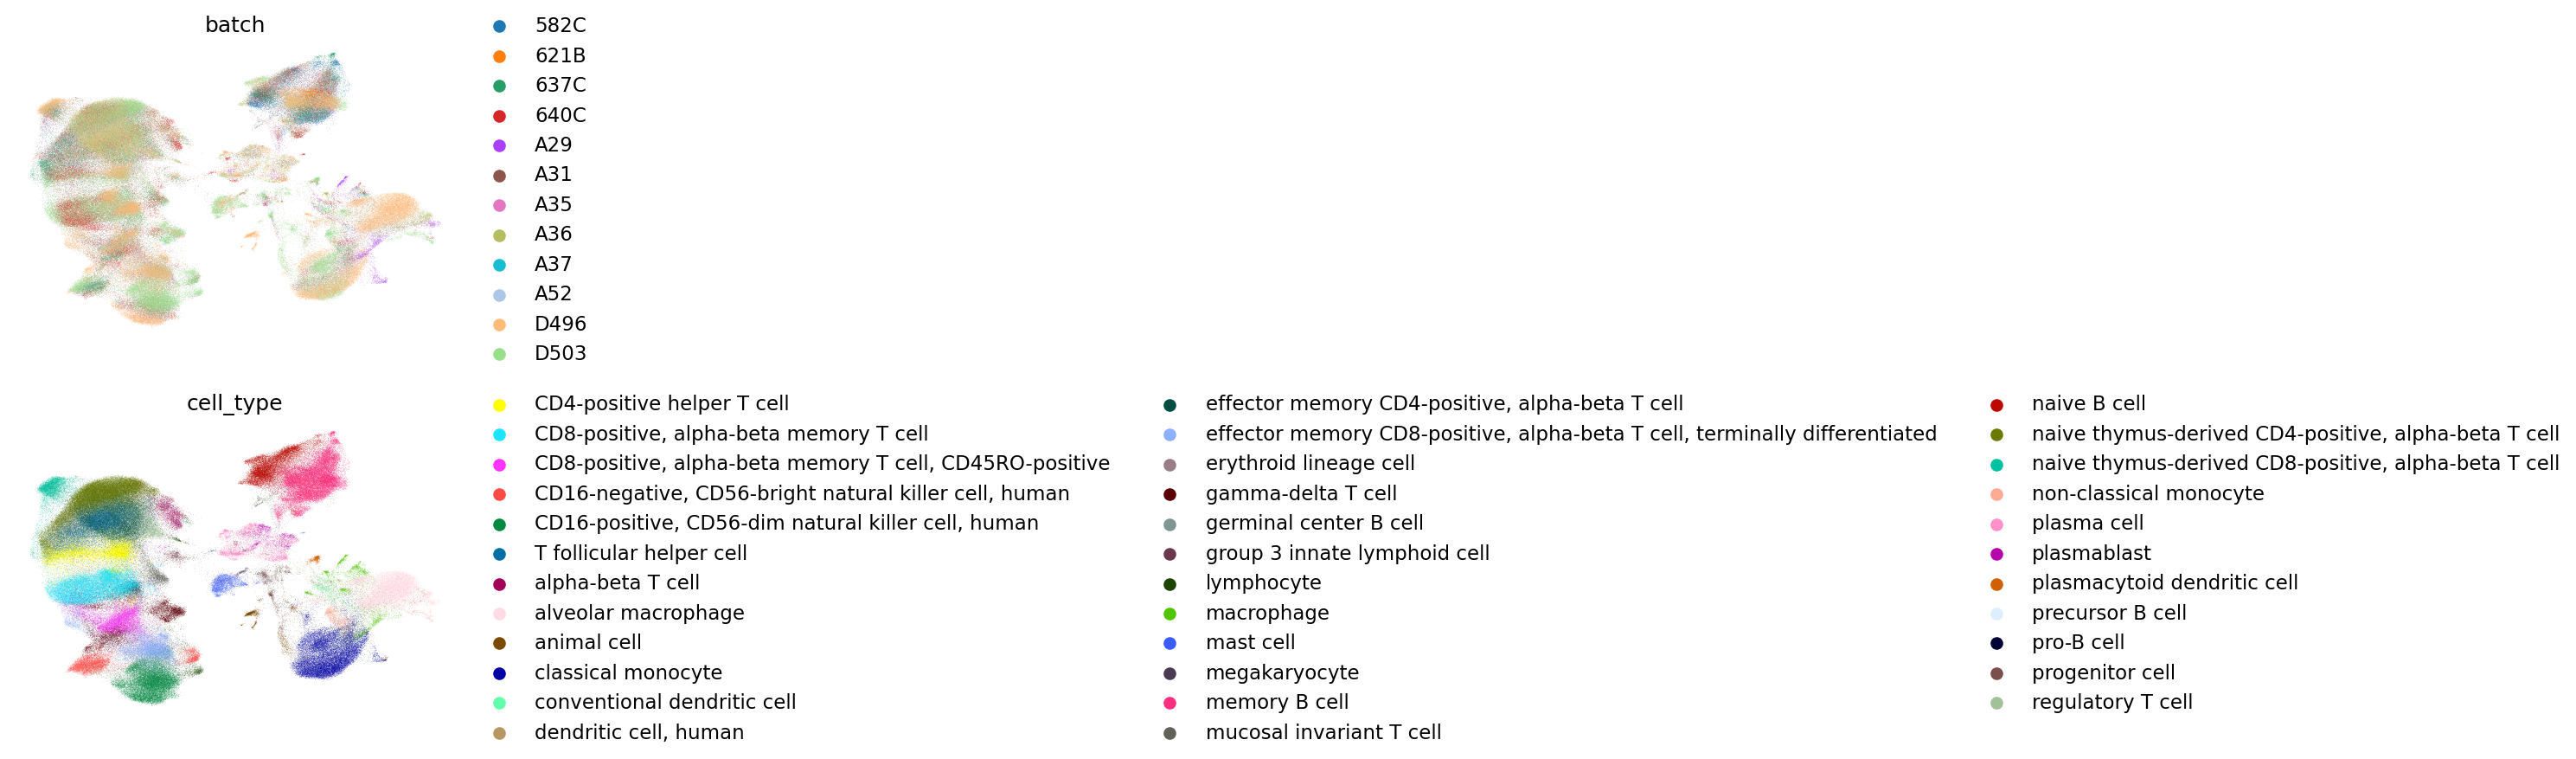

Combat


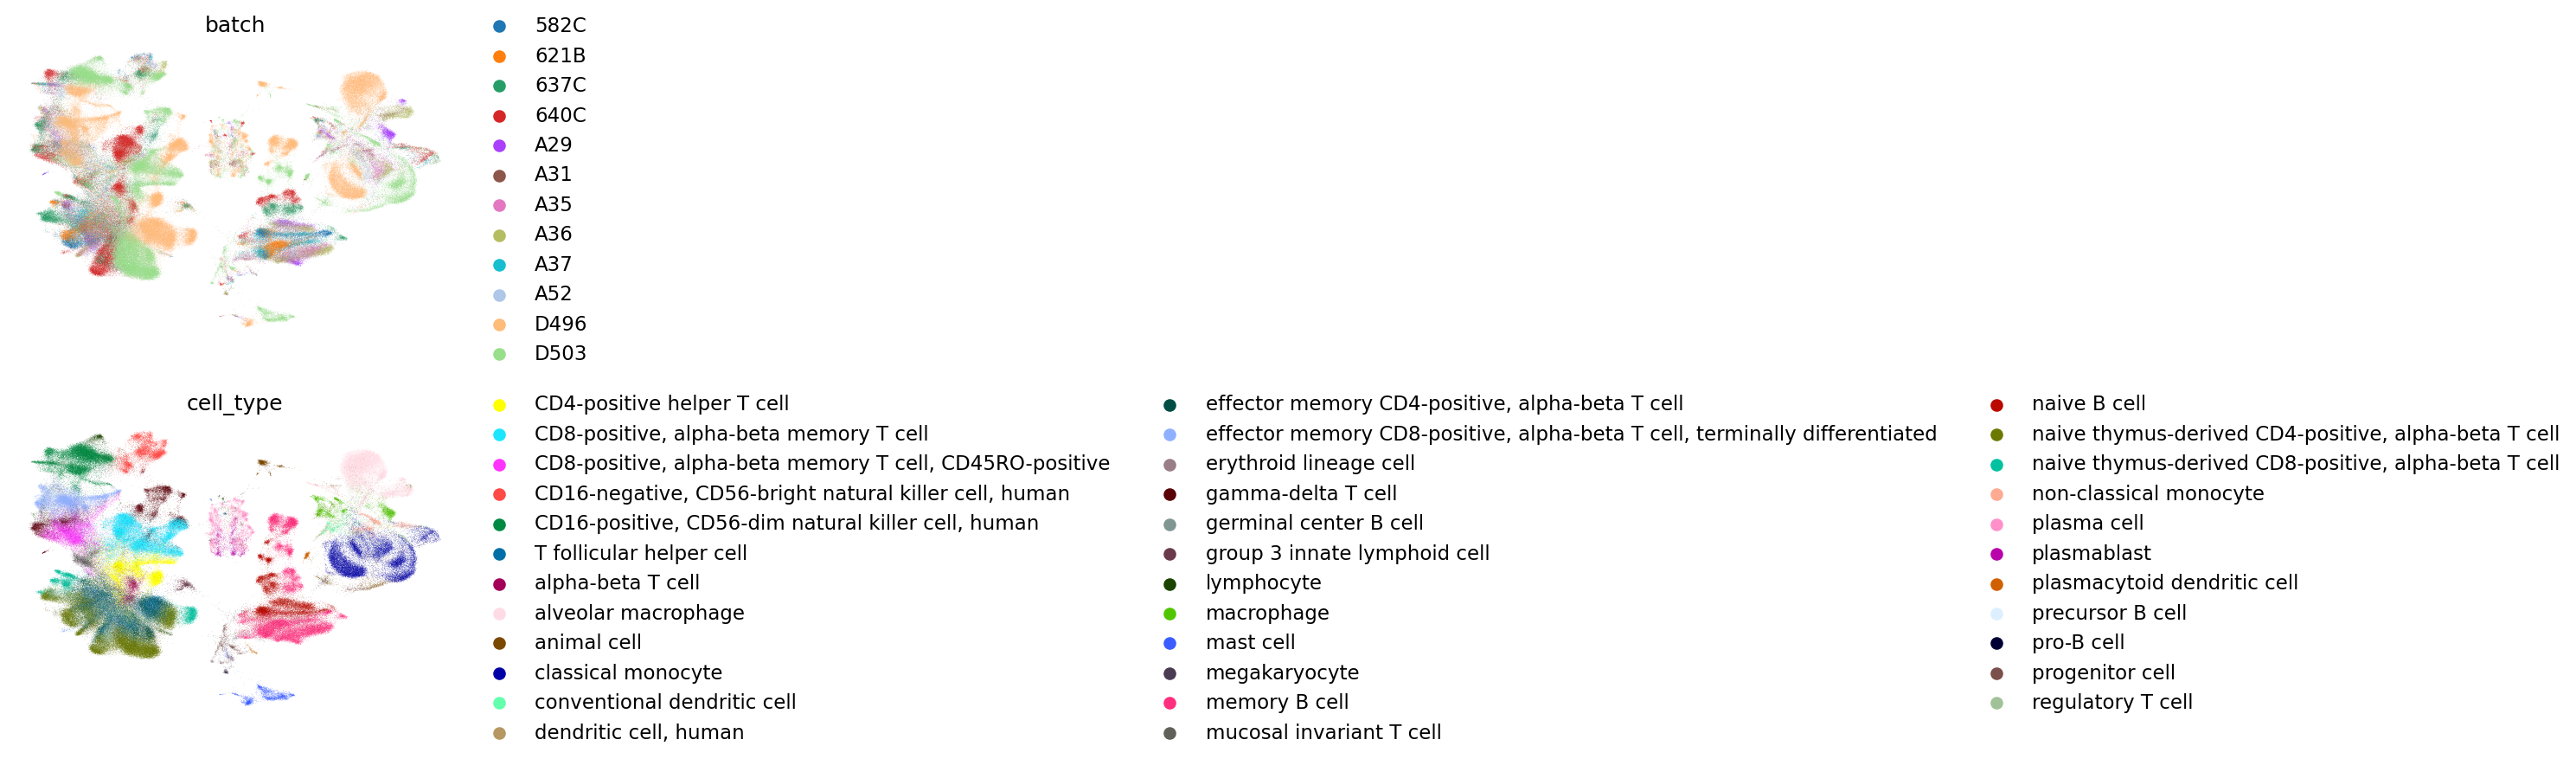

scVI


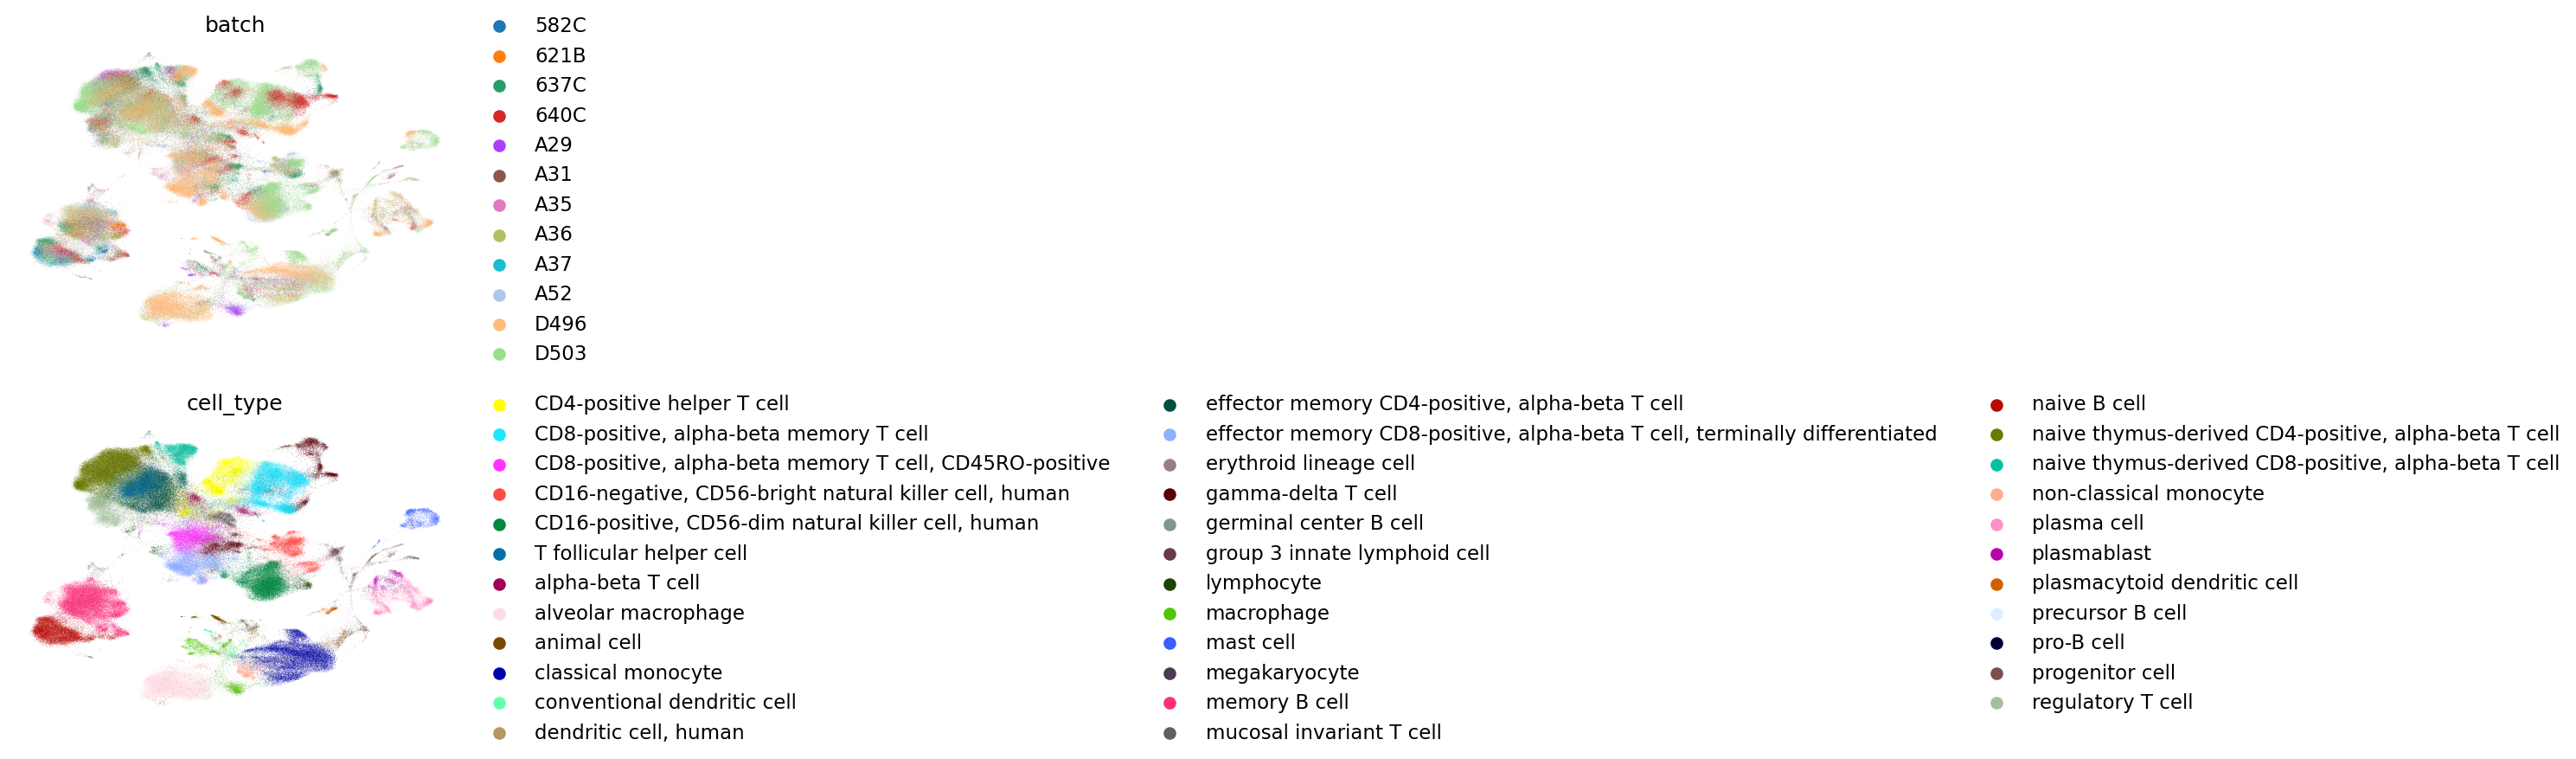

scANVI


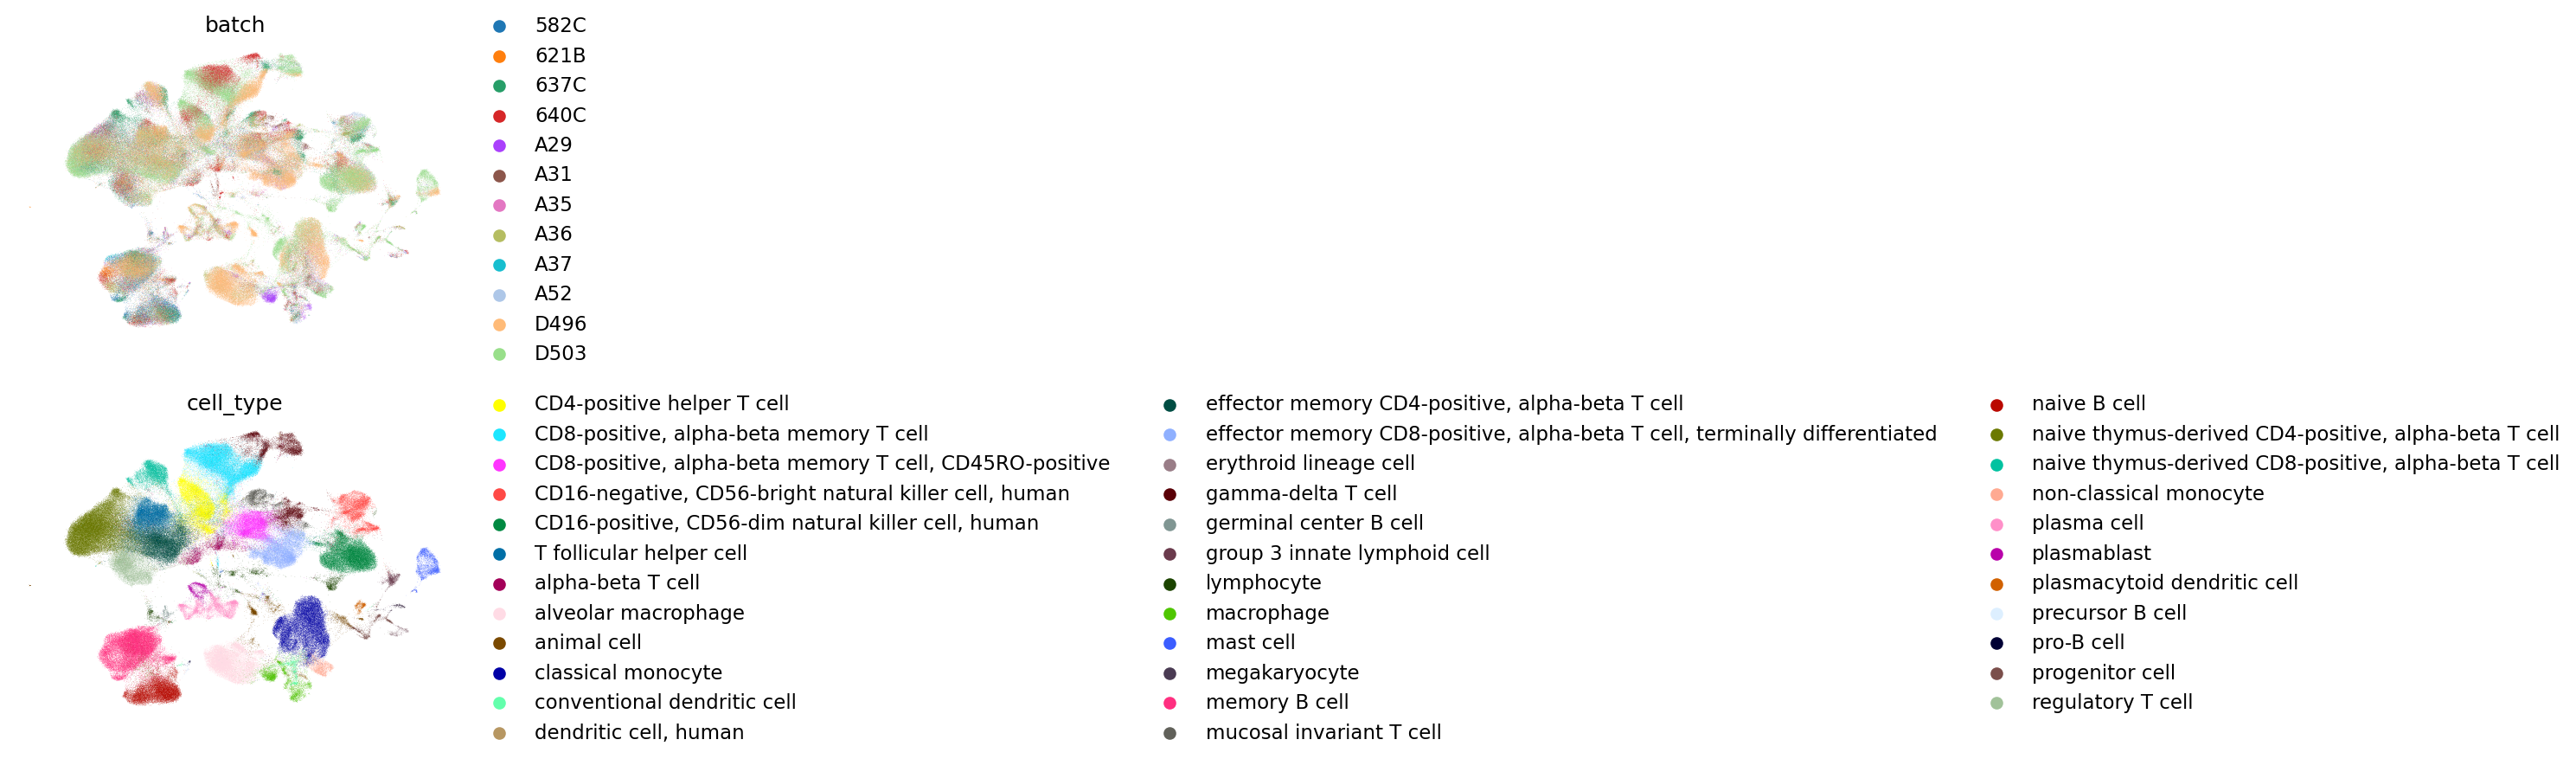

FADVI


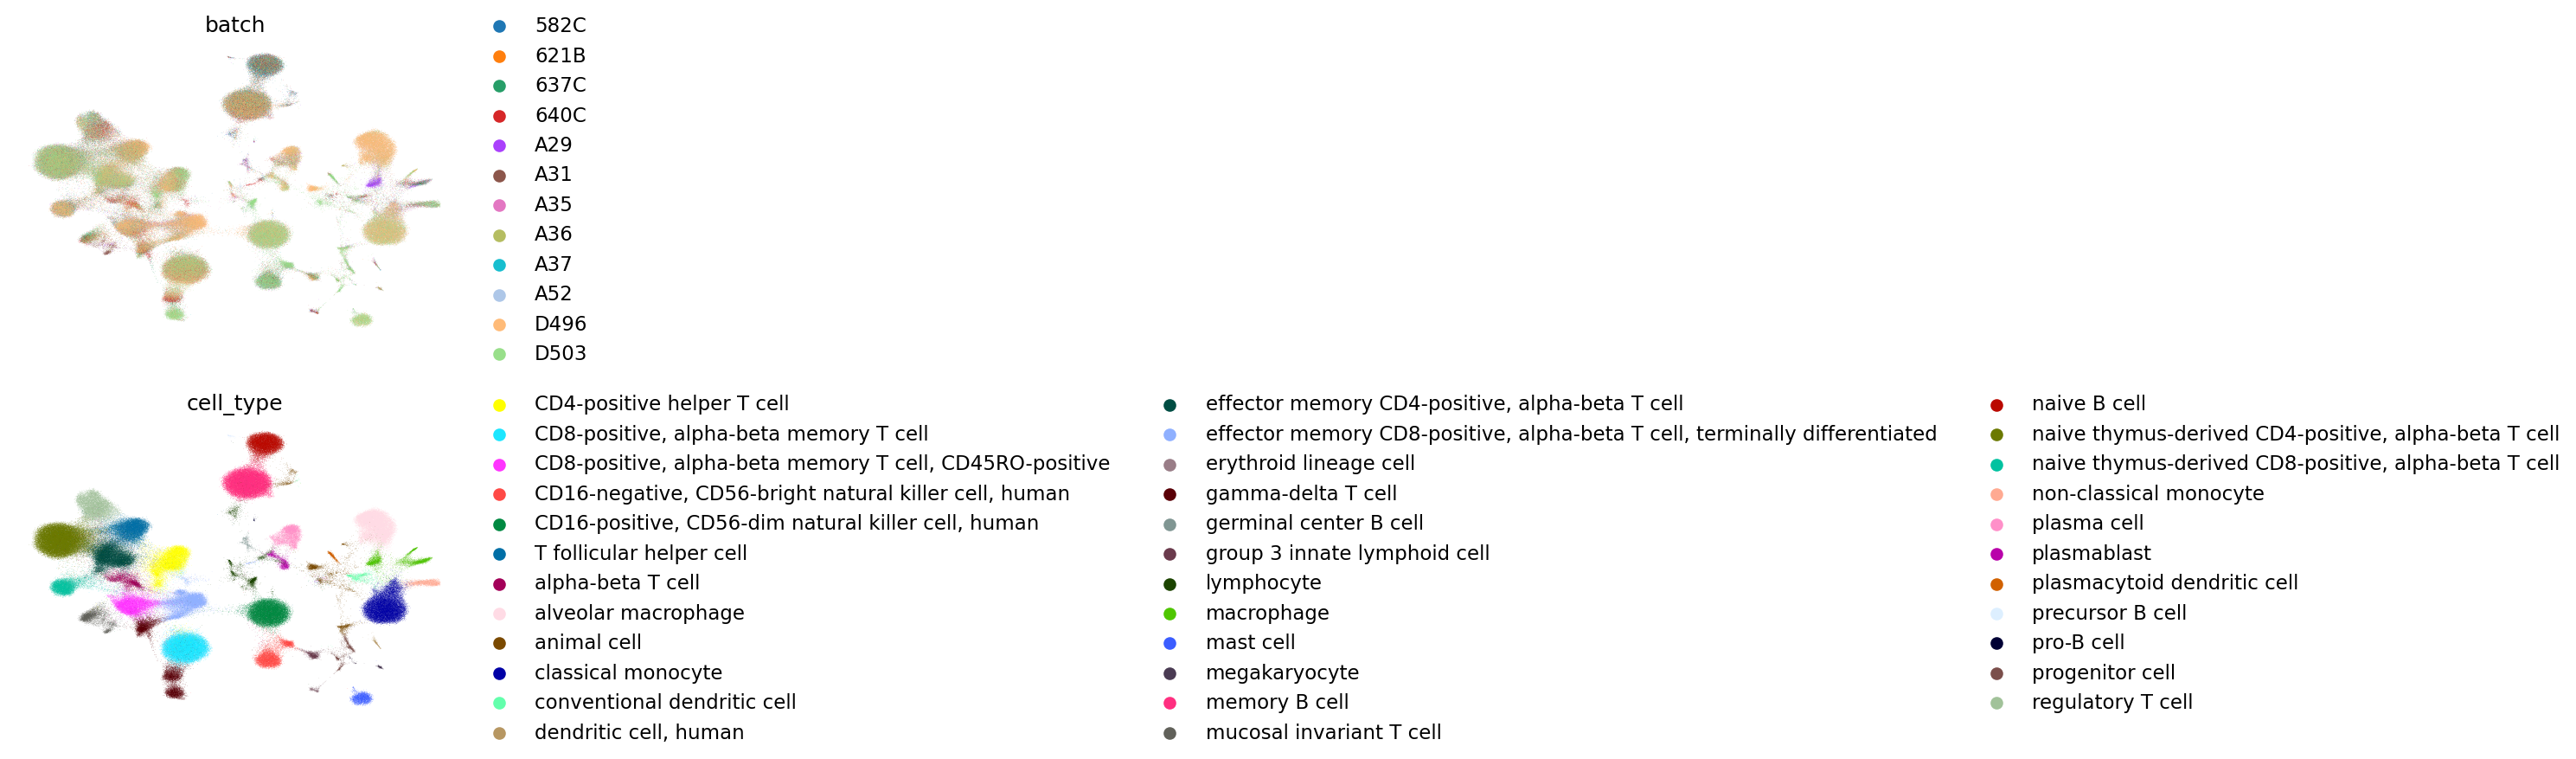

FADVI(semi)


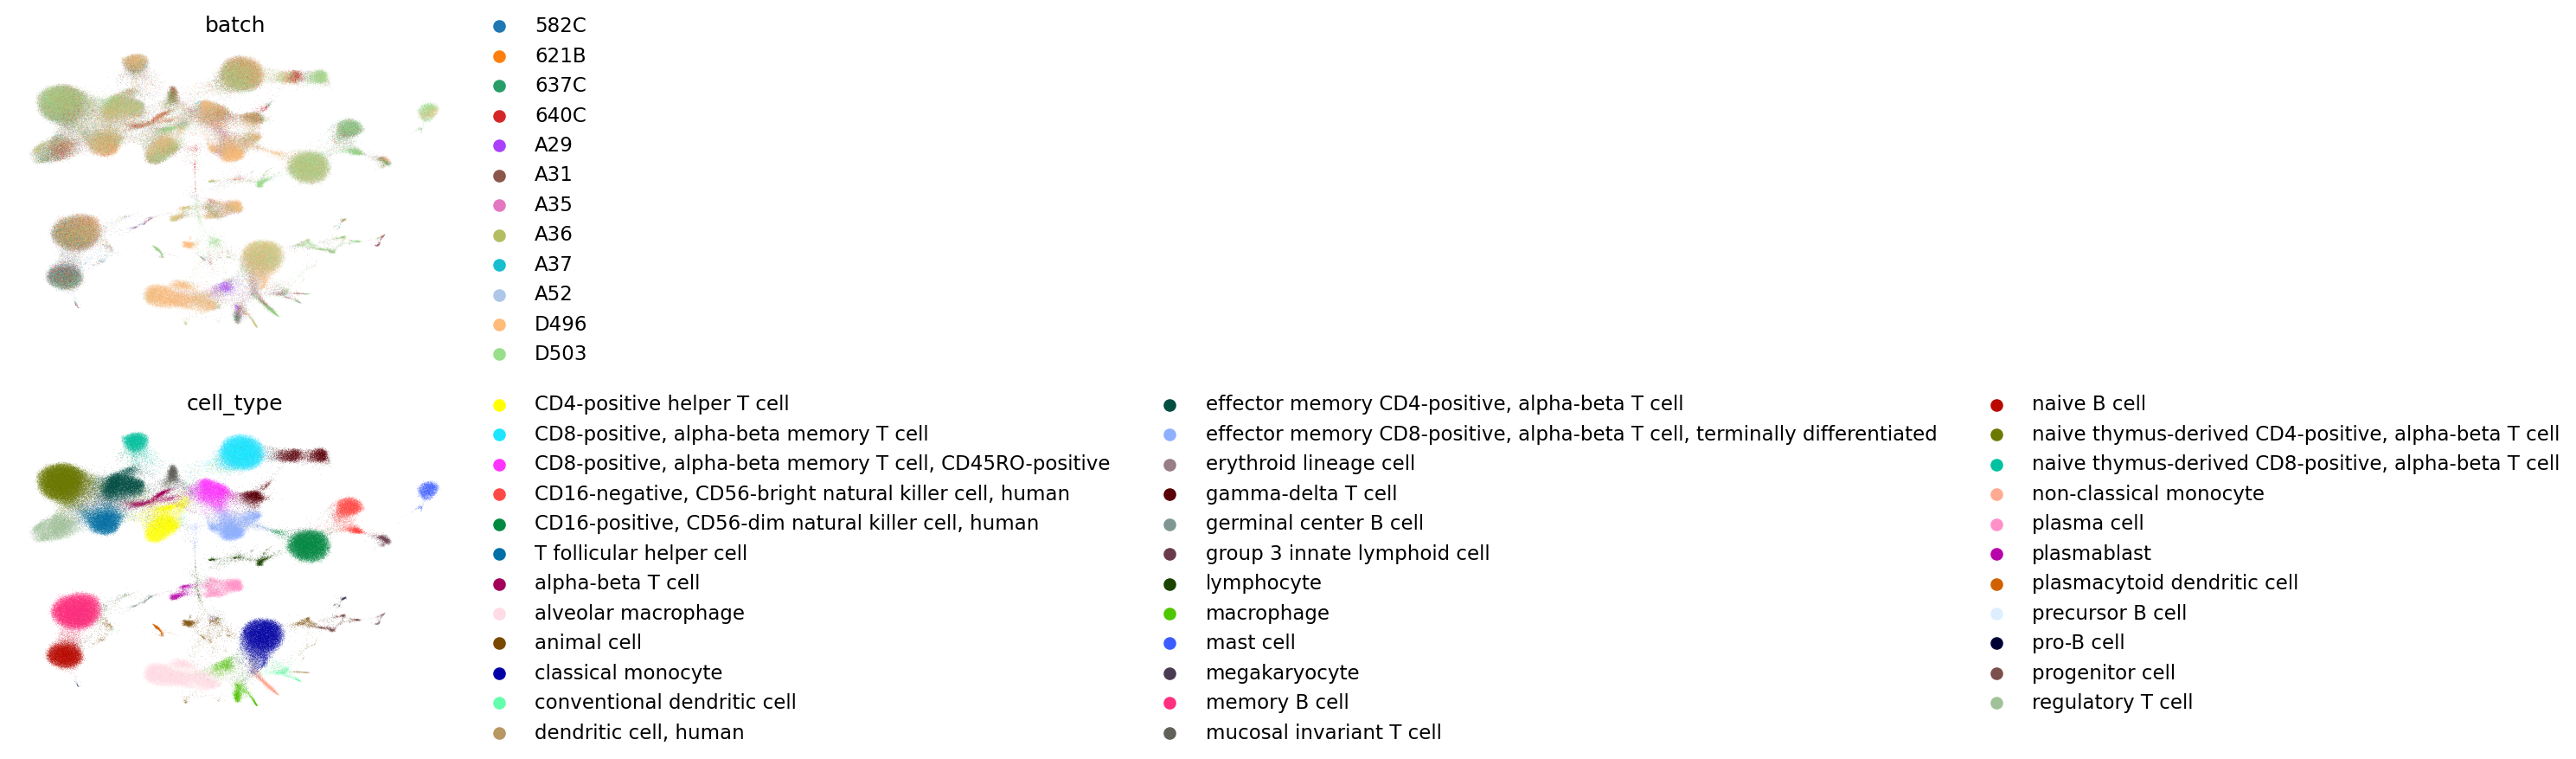

FADVI_batch


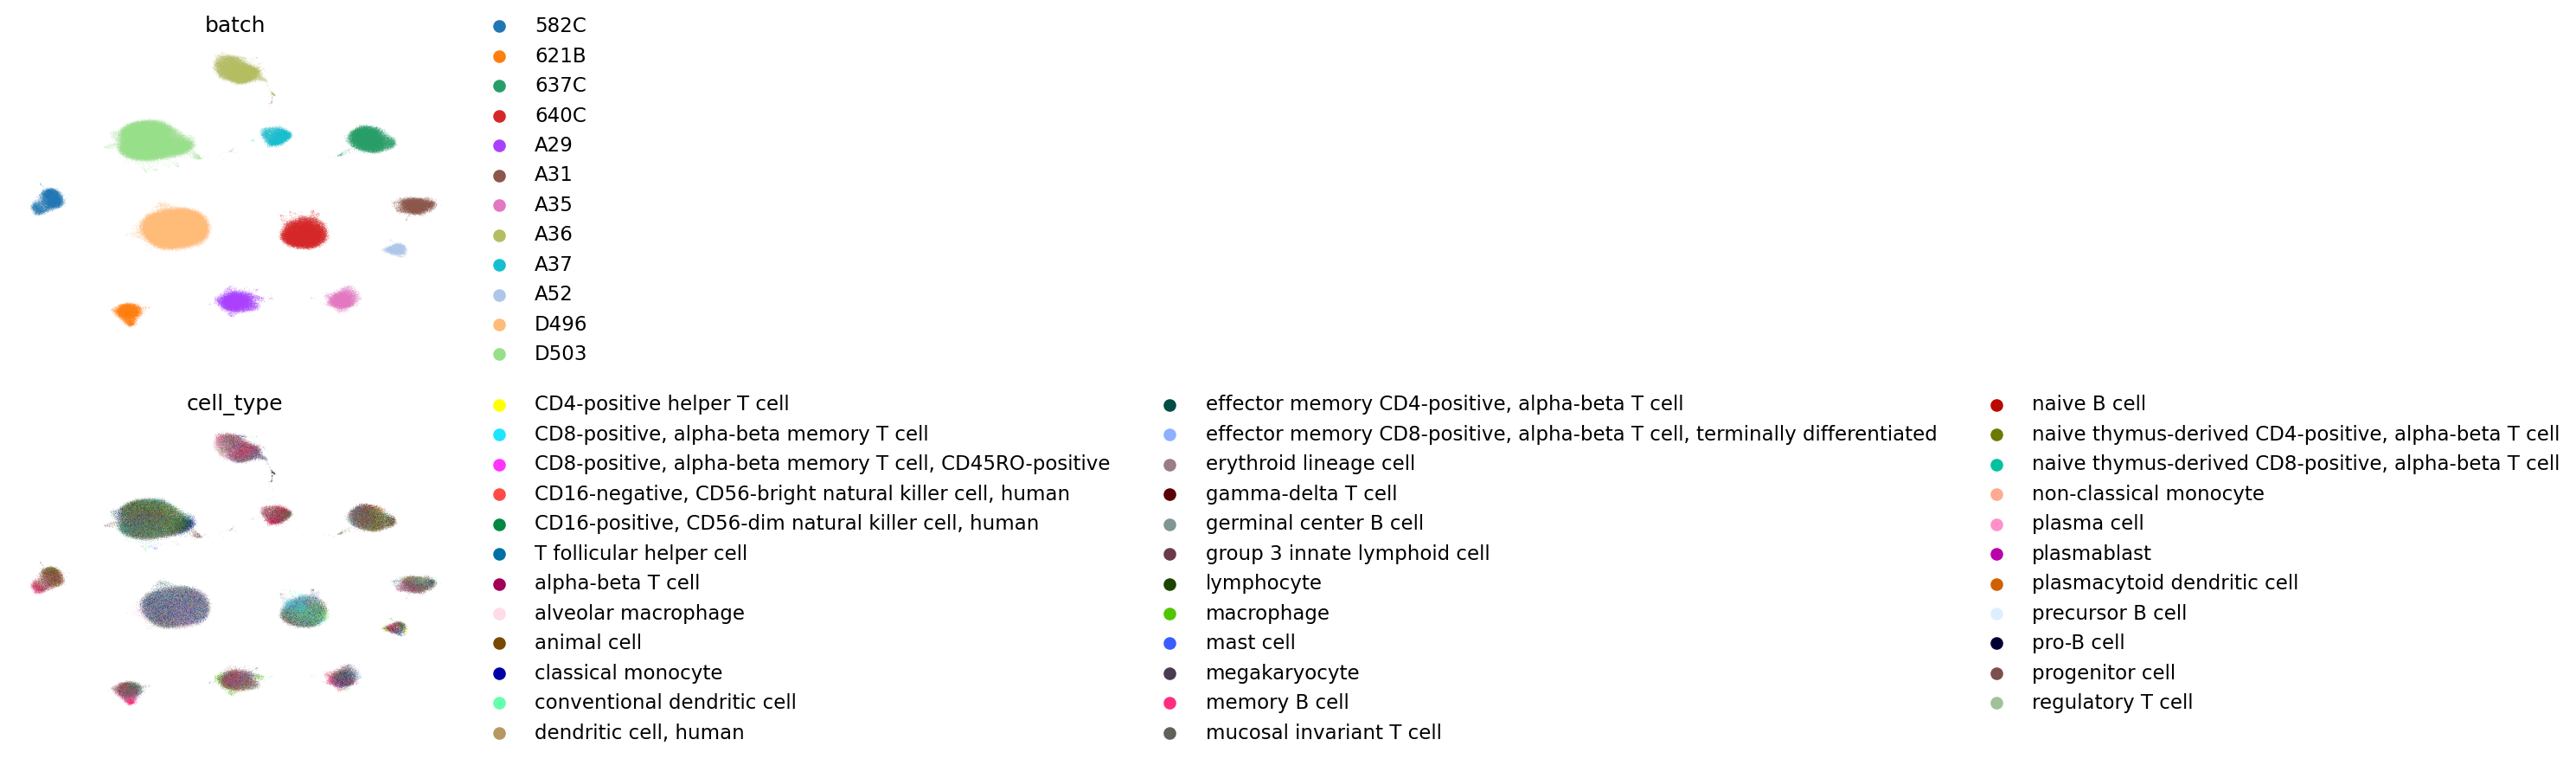

FADVI(semi)_batch


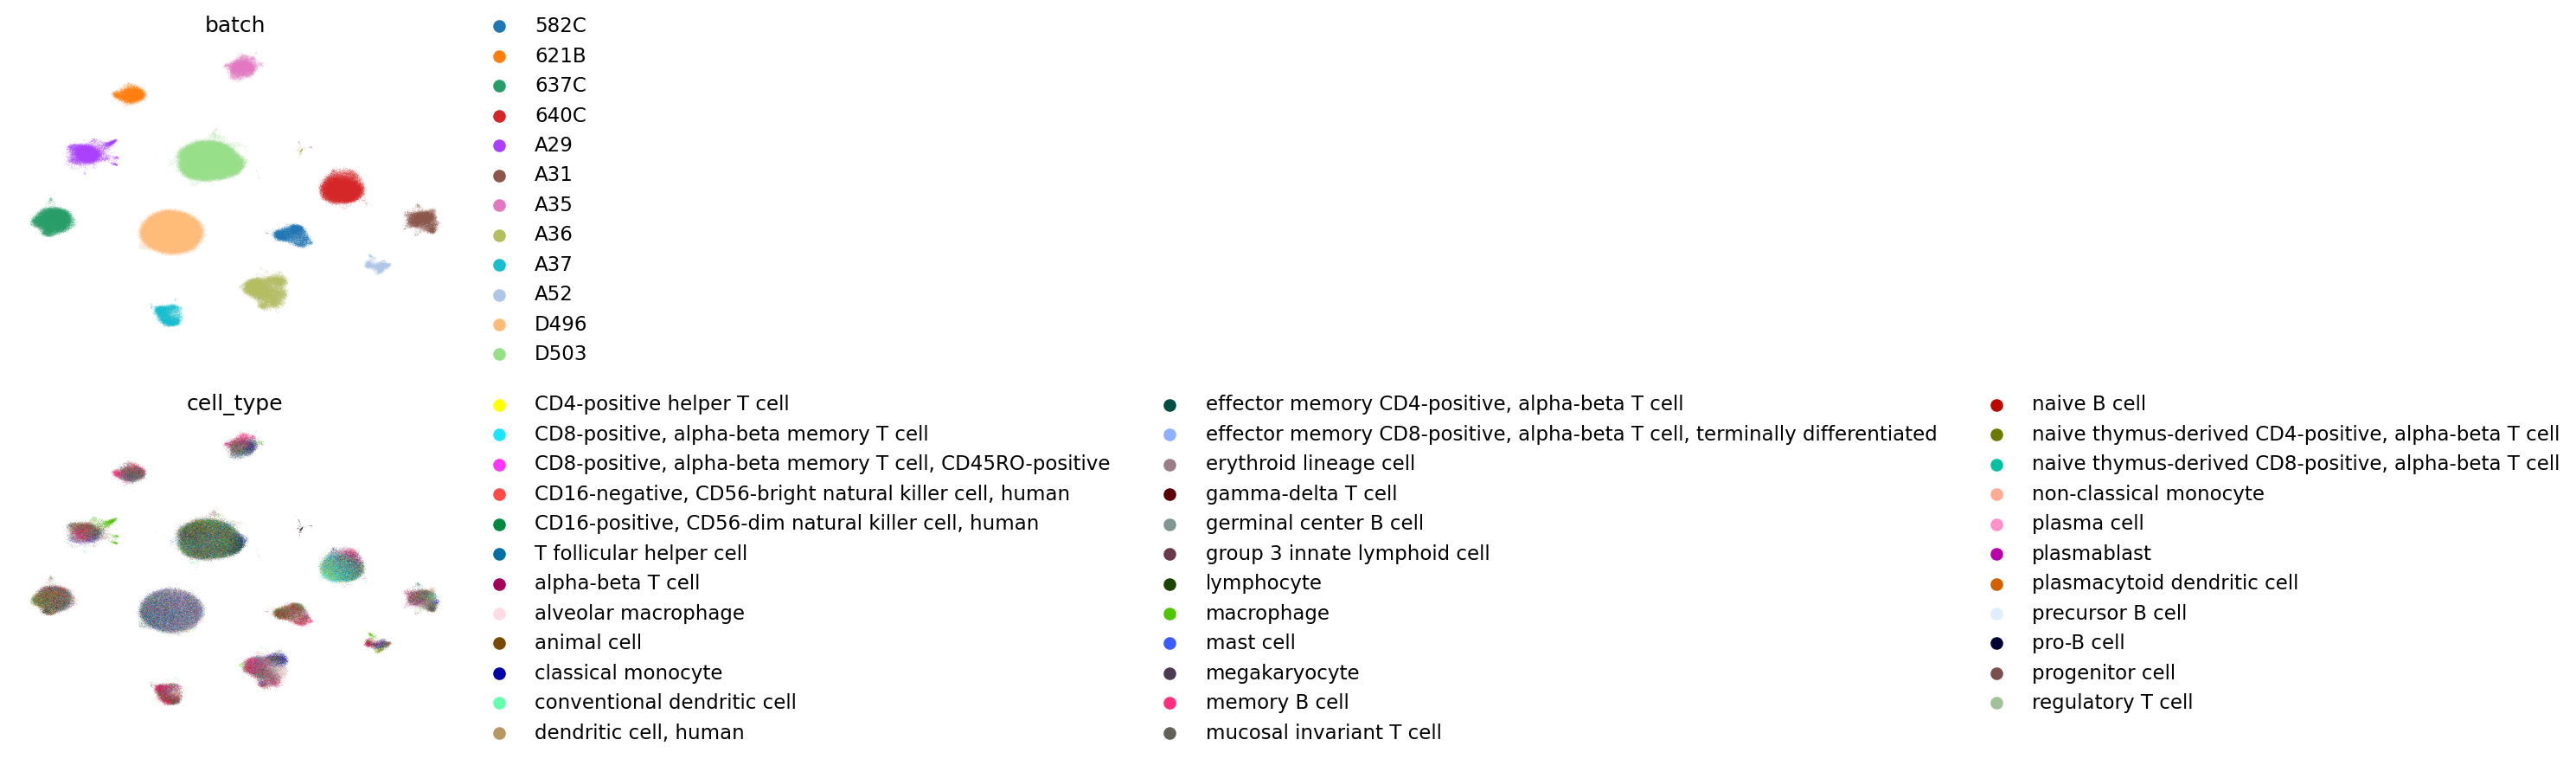

In [14]:
for emb_i in list(method_integration.keys()) + ["FADVI","FADVI(semi)","FADVI_batch","FADVI(semi)_batch"]:
    print(emb_i)
    sc.pp.neighbors(adata, use_rep=emb_i)
    sc.tl.umap(adata, key_added=f'X_umap_{emb_i}')
    sc.pl.embedding(
        adata, basis=f'X_umap_{emb_i}', 
        color=["batch","cell_type"], #
        frameon=False,
        ncols=1,
    )

In [15]:
adata.write_h5ad('data/immune_atlas_benchmark.h5ad')

## Quantitative Benchmarking

Now let's perform quantitative evaluation using scib-metrics to get objective performance scores.

In [16]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=list(method_integration.keys()) + ["FADVI","FADVI(semi)"],
    n_jobs=-1,
)
bm.benchmark()

/data/wliu12/miniconda3/envs/rnew/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:438: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Metrics:   0%|        | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]
Metrics:  10%| | 1/10 [00:24<03:39, 24.36s/it, Bio conservation: isolated_labels
Metrics:  10%| | 1/10 [00:24<03:39, 24.36s/it, Bio conservation: nmi_ari_cluster
Metrics:  20%|▏| 2/10 [00:28<01:40, 12.59s/it, Bio conservation: nmi_ari_cluster
Metrics:  20%|▏| 2/10 [00:28<01:40, 12.59s/it, Bio conservation: silhouette_labe
Metrics:  30%|▎| 3/10 [00:51<02:01, 17.32s/it, Bio conservation: silhouette_labe
Metrics:  40%|████▍      | 4/10 [00:52<01:05, 10.85s/it, Batch correction: bras]E0902 11:39:39.342973 1900091 hlo_lexer.cc:443] Failed to parse int l

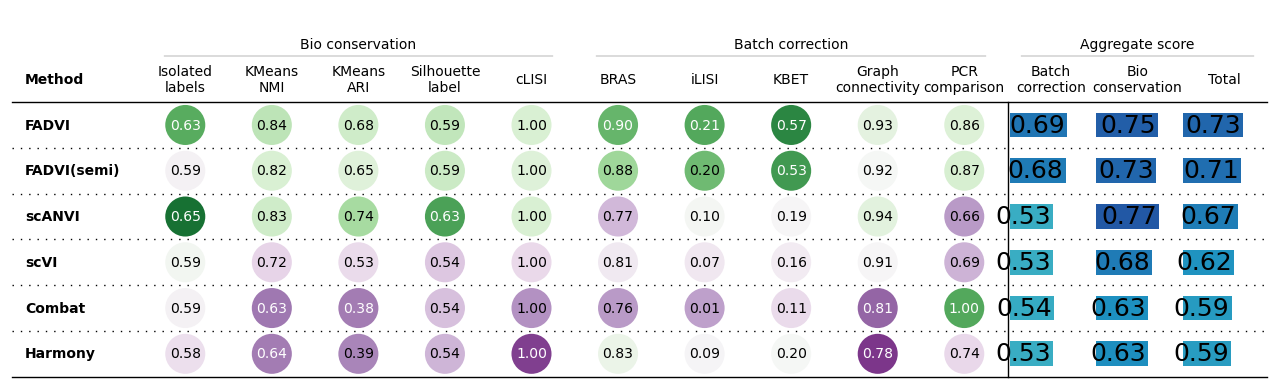

In [17]:
bm.plot_results_table()

In [18]:
bm.get_results().to_csv('csv/immune_atlas_benchmark.csv')